### 필요 라이브러리 import

In [2]:
%pylab
%matplotlib inline
import pandas as pd
import seaborn as sns
import tensorflow as tf

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


### 2개의  분포를 이용하여, 2000개의 랜덤 좌표를 생성

In [5]:
num_points = 2000
set_points = []

for i in xrange(num_points):
    if np.random.random() > 0.5:
        set_points.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
    else:
        set_points.append([np.random.normal(3.0, 0.5), np.random.normal(1.0, 0.5)])



                 x            y
count  2000.000000  2000.000000
mean      1.518383     0.525812
std       1.647328     0.882743
min      -2.268266    -2.737665
25%       0.052030     0.014549
50%       2.021663     0.681190
75%       2.998355     1.134495
max       4.548355     2.813885


### 발생된 랜덤 좌표를 Plot

,x,y
count,2000.000000,2000.000000
mean,1.518383,0.525812
std,1.647328,0.882743
min,-2.268266,-2.737665
25%,0.052030,0.014549
50%,2.021663,0.681190
75%,2.998355,1.134495
max,4.548355,2.813885


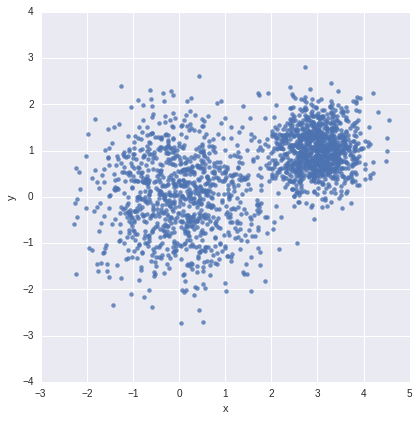

In [11]:
df = pd.DataFrame({"x" : [v[0] for v in set_points],
                   "y" : [v[1] for v in set_points]})
sns.lmplot("x", "y",data=df, fit_reg=False, size=6);
df.describe()

### 2000개의 좌표를 텐서 벡터로 변환하고 4개의 중심치를 선정

In [21]:
vectors    = tf.constant(set_points)       # 랜덤 포인트를 상수 텐서로 변
k          = 4                             # centroid 개수
shuffled   = tf.random_shuffle(vectors)    # vector 순서를 섞어 centroid 선정을 난수화
sliced     = tf.slice(shuffled, begin=[0, 0], size=[k, -1]) # 상위 4개 선정

centroides = tf.Variable(sliced)           # 선정된 데이터를 텐서변수로 변환

In [19]:
tf.random_shuffle?

In [20]:
tf.slice?

###  차원 확장

In [38]:
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroides = tf.expand_dims(centroides, 1)

print expanded_vectors.get_shape(), vectors.get_shape()
print expanded_centroides.get_shape(), centroides.get_shape()

(1, 2000, 2) (2000, 2)
(4, 1, 2) (4, 2)


![expand_dims](https://i2.wp.com/www.jorditorres.org/wp-content/uploads/2016/02/image031.gif)

### Squared uclidean distance

In [40]:
diff = tf.sub(expanded_vectors, expanded_centroides)
sqr = tf.square(diff)
distances = tf.reduce_sum(sqr,reduction_indices=[2])
assignments= tf.argmin(distances, dimension=0)

print diff.get_shape()
print sqr.get_shape()
print distances.get_shape()
print assignments.get_shape()

(4, 2000, 2)
(4, 2000, 2)
(4, 2000)
(2000,)


![sqr_euclidian_dist](https://i2.wp.com/www.jorditorres.org/wp-content/uploads/2016/02/image028.jpg)

차원 축약에 쓰이는 연산들

Operation      | Description
---------------|----------------------------------------------------------
tf.reduce_sum  | Computes the sum of the elements along one dimension
tf.reduce_prod | Computes the product of the elements along one dimension
tf.reduce_min  | Computes the minimum of the elements along one dimension
tf.reduce_max  | Computes the maximum of the elements along one dimension
tf.reduce_mean | Computes the mean of the elements along one dimension

인덱스를 리턴하는 연산들

Operation  |  Description
-----------|-------------------------------------------------------------------------
tf.argmin  |  Returns the index of the element with the minimum value along tensor dimension
tf.argmax  |  Returns the index of the element with the maximum value of the tensor dimension

###  새 중심치 계산

In [50]:
centroid_mean=[]
for c in range(k):
    eq = tf.equal(assignments, c) # Centroid C와 일치하는 Assignment 추출
    loc = tf.where(eq)            # eq로 부터 해당 위치 추출
    indices_flatten = tf.reshape(loc, [1, -1]) # 위치를 1차 배열로 정렬
    gathered = tf.gather(vectors,indices_flatten ) # 해당 data를 모음
    centroid_mean.append(tf.reduce_mean(gathered, reduction_indices=[1])) # 새 평균

In [49]:
tf.gather?

In [43]:
means = tf.concat(concat_dim=0, values=centroid_mean)

In [52]:
print means.get_shape()

(4, 2)


In [44]:
update_centroides = tf.assign(centroides, means)
init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)

for step in xrange(100):
    _, centroid_values, assignment_values = sess.run([update_centroides, centroides, assignments])
    

In [53]:
tf.assign?

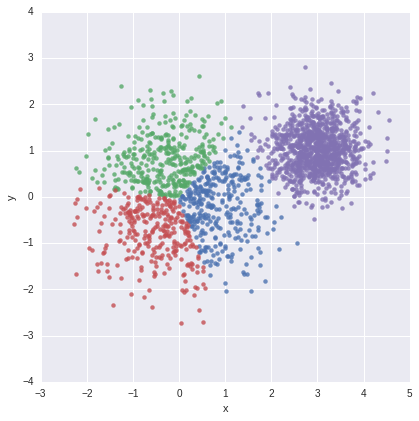

In [45]:
data = {"x":[],
       "y":[],
       "cluster":[]}

for i in xrange(len(assignment_values)):
    data["x"].append(set_points[i][0])
    data["y"].append(set_points[i][1])
    data["cluster"].append(assignment_values[i])
    
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False, size=6, hue="cluster", legend=False)
    

In [36]:
pd.DataFrame(data).groupby('cluster').std()

,x,y
cluster,,
0,0.616888,0.586504
1,0.633200,0.530240
2,0.502231,0.485609
3,0.498847,0.639881
